This notebook explores s-process nucleosynthesis via Jupyter technology and a simple s-process model.  As you read through the text, you can execute the code blocks.  You can change input (for example, choose different axis ranges or scaling or select different species to show in the plots).  You can right-click or control-click on figures to save them.  If your current version gets corrupted, don't worry.  Simply quit and download a new copy from GitHub, or start up a new version on Google Colab or Binder.

## Table of Contents:

[Introduction](#introduction)<br/>
[Preliminaries](#preliminaries)<br/>
[Model](#model)<br/>
[S Process at Constant Neutron Density](#s_process)<br/>
[Distribution of Exposures](#distribution)<br/>

<a id='introduction'></a>
# Introduction

The [s process](https://en.wikipedia.org/wiki/S-process) is the *slow* neutron capture process in the sense that the average neutron capture timescale is slow  compared to the average beta decay rate.  In this way, if nuclei become beta unstable after capturing a neutron, they will preferentially decay over capturing another neutron.  This is in contrast to the [r (*rapid*) process](https://en.wikipedia.org/wiki/R-process), in which a nucleus captures many neutrons before beta decaying.

The s process predominantly occurs during helium burning in stars during which $^4{\rm He}$ nuclei combine to make $^{12}{\rm C}$ and $^{16}{\rm O}$.  If neutron source nuclei like $^{13}{\rm C}$ and $^{22}{\rm Ne}$ are available from previous buring, then neutrons can be produced by reactions such as $^{12}{\rm C} + ^4{\rm He} \to ^{16}{\rm C} + n$.  The neutrons thus produced can be captured by other nuclei to drive the s process.

Strong s processing occurs during the helium shell burning in [AGB](https://en.wikipedia.org/wiki/Asymptotic_giant_branch) stars or in the core and shell helium burning in [massive stars](https://en.wikipedia.org/wiki/Star#Massive_stars).  The final s-process abundance distribution in some sample is the result of a variety of s-process conditions, which can be characterized by a distribution of neutron exposures, as described below.

This notebook studies s-process nucleosynthesis with single-zone network calculations run at constant temperature and neutron density.  The data are read across the web from [OSF](https://osf.io/6b5gk/).  The user is then able to  study the evolution of the abundances with changing neutron exposure and the abundances resulting from particular distributions of neutron exposure.

<a id='preliminaries'></a>
# Preliminaries

We first need to perform some preliminary operations to set up the notebook.  First we import packages and download data. First, import the necessary packages and download the necessary data. Installing wnutils will automatically also install numpy and matplotlib.

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnutils

The next step is to import the packages to check for and retrieve the data:

In [2]:
import os, io, requests
from lxml import etree

This notebook uses [wnutils](https://wnutils.readthedocs.io) to analyze the nucleosyntheis [XML](https://www.w3.org/TR/REC-xml/) output, so the next code block imports that package.  It also imports the matplotlib and numpy packages.

In [3]:
import wnutils.xml as wx
import wnutils.multi_xml as mx
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

<a id='model'></a>
# Model

In this section, you choose the model for study.  This cell prints out the names of the available models.

In [4]:
models_xml = etree.parse(io.BytesIO(requests.get('https://osf.io/dsqr5/download').content))

models = (models_xml.getroot()).xpath("model")

for m in models:
    print((m.xpath("//name"))[0].text, ":", (m.xpath("//short_desc"))[0].text)

model1 : Default input.  n_n = 1.0e8 n/cm^3.


Choose the model.  The cell then prints out a description of the model and reads the file from [OSF](https://osf.io/6b5gk/).

In [5]:
model = 'model1'

xpath_str = "model[name = " + "'{}'".format(model) + "]"
model_element = (models_xml.getroot()).xpath(xpath_str)[0]
desc = model_element.xpath("//long_desc")[0].text
print(desc)

xml = wx.Xml(io.BytesIO(requests.get((model_element.xpath("//url"))[0].text).content))

Input:  rho = 1.0e3 g/cm^3, T9 = 0.25, X_n = 1.66e-19 n/cm^3 giving n_n = 1.e8 n/cm^3.  Input mass fractions from zone with label1 = 186 of he_burning output mainline-nucleosynthesis project with default parameters.


<a id='s_process'></a>
## S Process at Constant Neutron Density

The present simple model simply assumes a constant neutron density and temperature and only allows neutron capture and beta decay reactions.  The initial abundances are taken from some point in helium burning.  The next cell prints out the conditions for the model.

In [6]:
props = xml.get_properties_as_floats(['time','t9', 'rho'])
x_n = xml.get_mass_fractions(['n'])['n']
n_n = x_n[len(x_n)-1] * props['rho'][len(props['rho'])-1] * 6.022e23
print('For the calculation, the duration, temperature, mass density, and neutron density were:')
print('   time (yr) = {0:.2e}'.format(props['time'][len(props['time'])-1] / 3.15e7))
print('   T (K) = {:.2e}'.format(props['t9'][len(props['t9'])-1] * 1.e9))
print('   mass density (g/cc) = {:.2e}'.format(props['rho'][len(props['rho'])-1]))
print('   neutron density (per cc) = {:.2e}'.format(n_n))

For the calculation, the duration, temperature, mass density, and neutron density were:
   time (yr) = 1.00e+05
   T (K) = 2.50e+08
   mass density (g/cc) = 1.00e+03
   neutron density (per cc) = 1.00e+08


A convenient parameter for discussion of the evolution of the neutron captures is the neutron exposure $\tau$.  It is mathematically defined as $\tau(t) = \int_0^t n_n(t') v_T(t') dt'$, where $n_n(t)$ is the neutron density (number of neutrons per cubic centimeter) at time $t$ and $v_T(t)$ is the thermal velocity of the neutrons at time $t$.  Physically, the exposure is the total number of neutrons that pass through an area in duration from time 0 to $t$.  For s-process studies, it is convenient to use the units inverse millibarns, where a millibarn ($mb$), 1/1000 of a [barn](https://en.wikipedia.org/wiki/Nuclear_cross_section), has units $10^{-27}$ cm$^2$.  Notice that if a species only changes abundance by capturing neutrons, then its abundance $Y(\tau)$ is governed by the differential equation $dY(\tau)/d\tau = -\sigma Y(\tau)$, where $\sigma$ is the species' cross section in $mb$.  This means that the abundance behaves as $Y(\tau) = Y(0) e^{-\sigma \tau}$.  Thus, the exposure needed for a species with cross section $\sigma$ to capture a neutron is about $1/\sigma$.  s-process nuclei typically have cross sections in the range 10's to 100's of $mb$.

The following code block shows the evolution of the neutron exposure in the calculation as a function of time.  Since the neutron density and temperature were held constant in the calculation, the exposure rises linearly with the time.

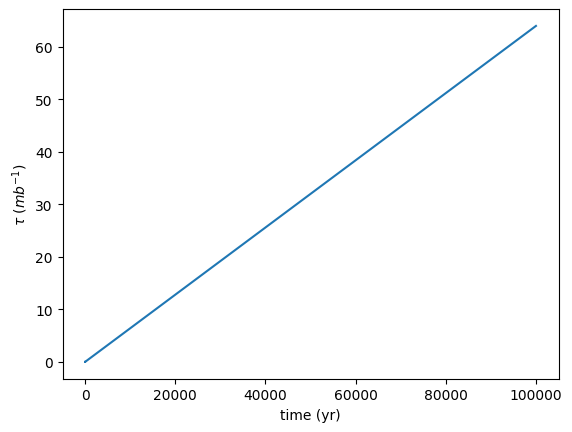

In [7]:
xml.plot_property_vs_property('time', ('exposure','n'), xfactor = 3.15e7, xlabel='time (yr)',
                                ylabel='$\\tau\ (mb^{-1})$')

This next cell creates an animation showing how the abundances as a function mass number evolve with increasing neutron exposure in the s process. Note that the abundances are relative to the total number of nucleons in the system. One may also think of this scaling as the moles of the species per mole of nucleons, or, as the number of moles of the species per gram of material.

Neutron captures and beta decays increase the mass of the original seed nuclei (the ashes of hydrogen burning plus Solar abundances for elements heavier than silicon). This causes the "upward" movement in mass number in the movie below. The neutron capture s-process chain terminates at $^{209}$Bi by the loop $^{209}{\rm Bi} + n \ \to ^{210}{\rm Bi} + \gamma$, followed by $^{210}{\rm Bi} \to ^{210}{\rm Po} + e^- + \nu_e$, and then $^{210}{\rm Po} \to ^{206}{\rm Pb} + \alpha$. The $^{206}$Pb then undergoes further neutron capture and beta decay to $^{209}$Bi to complete the cycle. Any nuclei entering the cycle from lower mass get caught up in it, leading to build up of the Pb and Bi isotopes.  Notice also the slight build of up $^4{\rm He}$ from the alpha decays.

The "bouncing" behavior one can see at late time (large exposure) results from the fact that the abundance pattern achieves a steady-state form above mass number 90 or so. For any species in the chain, neutron capture or beta decay into that species is balanced by capture or decay out. The overall level of the steady-state pattern is then set by the flow of abundance into the chain from lower mass number. As this flow varies due to variations in the neutron-capture flow from the lower-mass seed nuclei, the overall pattern rises or falls.
The default zone XPath selects time steps after one year in the calculation and with exposure less than 20 inverse millibarns. To select all time steps, uncomment the following my_xpath line (that is, remove the # to select my_xpath = "").

In [8]:
def my_title(props, i):
    title_str = \
    "$\\tau$ = %4.2f ($mb^{-1}$)" % \
    (props[('exposure', 'n')][i])
    return (title_str, {'fontsize': 14, 'color': 'black'})
    
my_xpath = "[(optional_properties/property[@name = 'exposure' and @tag1 = 'n'] < 20) and \
             (optional_properties/property[@name = 'time'] > 3.15e7)]"
#my_xpath = ""

props = xml.get_properties_as_floats([('exposure', 'n')], zone_xpath = my_xpath)
bind = lambda i: my_title(props, i)

ya = xml.get_abundances_vs_nucleon_number(zone_xpath = "[position() = 1]")
my_extra = [(np.arange(len(ya[0])), ya[0], {'lw': 0.3, 'color': 'blue', 'label': 'Initial'})]

anim = xml.make_abundances_vs_nucleon_number_movie(zone_xpath = my_xpath, ylim = [1.e-12,1], yscale = 'log',
                                                    xlim = [0,250], xlabel = 'Mass Number, A',
                                                    ylabel = 'Abundance per nucleon', extraFixedCurves=my_extra,
                                                    plotParams={'label': 'Current'},
                                                    legend={'loc': 'upper right'}, title_func = bind)

display(HTML(anim.to_jshtml()))
plt.close()

In the next cell, choose a set of nuclei and plot their mass fractions as a function of neutron exposure.  Mass fractions are different from abundances in that mass fractions are the number of grams of a species per gram of material.  Adjust the plot parameters according to your purposes.

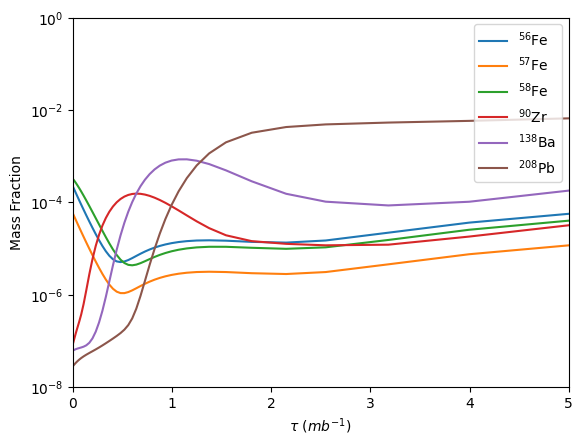

In [9]:
species = ['fe56', 'fe57', 'fe58', 'zr90', 'ba138', 'pb208']
xml.plot_mass_fractions_vs_property(('exposure', 'n'), species, yscale = 'log', ylim = [1.e-8, 1.], xlim = [0,5],
                                   use_latex_names = True, xlabel = '$\\tau\ (mb^{-1})$')

<a id='distribution'></a>
## Distribution of Exposures

The ensemble of nuclei undergoing s-process nucleosynthesis does not see a single neutron exposure but, because of the complicated interplay of hydrogen and helium shell burning in the AGB star, the complicated mixing during core and shell burning in a massive star, or the overall s-process contributions from all stars in Galactic chemical evolution, experiences rather a distribution $\rho(\tau)$ of such exposures.  Early [studies](https://ui.adsabs.harvard.edu/abs/1974ApJ...193..397C/abstract) used an exponential distribution of exposures such that $\rho(\tau) = \frac{1}{\tau_0} e^{-\tau/\tau_0}$, where $\tau_0$ is the mean exposure.  For such a distribution, most nuclei see little exposure and a smaller fraction of nuclei see larger exposures.  Those early studies found that an exponential distribution with $\tau_0 = 0.3\ mb^{-1}$ fits the solar s-process abundance distribution fairly well.  This section allows you to explore various exponential distributions of exposure.  Begin by defining the routine to compute the abundances for a given $\tau_0$.

In [10]:
def compute_s_proc_average(my_xml, tau_0):
    props = xml.get_properties_as_floats([('exposure', 'n')])
    y = my_xml.get_all_abundances_in_zones()
    
    dtau = []
    tau_old = 0

    for tau in props[('exposure','n')]:
        dtau.append(tau - tau_old)
        tau_old = tau

    result = []
    for t in tau_0:
        if t < 0:
            raise Exception("tau_0 must be >= 0")
        w = 0
        y_sum = np.zeros((y.shape[1], y.shape[1] + y.shape[2]))
        
        if t > 0:
            for i in range(y.shape[0]):
                factor = dtau[i] * np.exp(-props[('exposure','n')][i] / t) / t
                w += factor
                for z in range(y.shape[1]):
                    for n in range(y.shape[2]):
                        y_sum[z,z+n] += y[i,z,n] * factor
                
            y_sum /= w
        else:
             for z in range(y.shape[1]):
                    for n in range(y.shape[2]):
                        y_sum[z,z+n] += y[0,z,n]
        result.append(y_sum)
 
    return result

Now plot the abundances versus mass number for several distributions of exposure.  Choose the average exposures $\tau_0$.  The larger $\tau_0$, the greater the abundance of heavier species.

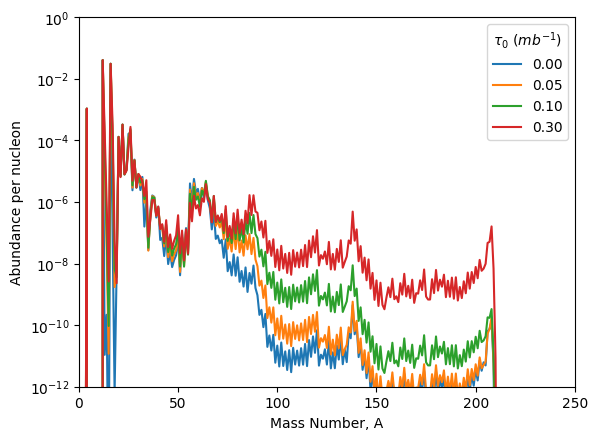

In [11]:
tau_0 = [0, 0.05, 0.1, 0.3]

ys = compute_s_proc_average(xml, tau_0)
for i in range(len(tau_0)):
    ya = np.sum(ys[i], axis=0)
    plt.plot(ya, label='{:.2f}'.format(tau_0[i]))
    
plt.yscale('log')
plt.xlim([0,250])
plt.ylim([1.e-12,1])
plt.xlabel('Mass Number, A')
plt.ylabel('Abundance per nucleon')
plt.legend(title='$\\tau_0\ (mb^{{-1}})$')
plt.show()